In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, joblib
from torch.utils.data import DataLoader,TensorDataset
from torch.autograd import grad

In [2]:
import numpy as np

# Define the paths and languages
data_path = "/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/23lang_wav2_vec_features/"
languages = ["Assamese", "Bengali", "Bodo", "Dogri", "English", "Gujarati", "Hindi", "Kannada",
             "Kashmiri", "Konkani", "Maithili", "Malayalam", "Manipuri", "Marathi", "Nepali",
             "Odia", "Punjabi", "Sanskrit", "Santali", "Sindhi", "Tamil", "Telugu", "Urdu"]

# Define indices for Indo-Aryan and Dravidian languages
indo_aryan_indices = [languages.index(lang) for lang in ["Bengali", "Marathi", "Punjabi", "Gujarati"]]
dravidian_indices = [languages.index(lang) for lang in ["Tamil", "Telugu", "Kannada", "Malayalam"]]
hindi_index = languages.index("Hindi")

# Function to load data for each language
def load_language_data(language):
    X_train_lang = np.load(data_path + f"X_train_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    y_train_lang = np.load(data_path + f"y_train_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    X_test_lang = np.load(data_path + f"X_test_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    y_test_lang = np.load(data_path + f"y_test_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    return X_train_lang, y_train_lang, X_test_lang, y_test_lang

# Filter and balance data function
def filter_and_balance_data(X, y, indo_aryan_indices, dravidian_indices, hindi_index, use_bengali_instead_of_hindi=False):
    indo_aryan_mask = np.isin(y, indo_aryan_indices)
    dravidian_mask = np.isin(y, dravidian_indices)
    hindi_mask = (y == hindi_index)

    if use_bengali_instead_of_hindi:
        hindi_index = languages.index("Hindi")
        indo_aryan_mask = indo_aryan_mask & (~hindi_mask)
        indo_aryan_mask[hindi_index] = True

    X_indo_aryan = X[indo_aryan_mask]
    y_indo_aryan = y[indo_aryan_mask]

    X_dravidian = X[dravidian_mask]
    y_dravidian = y[dravidian_mask]

    # Create binary labels for training set
    X_train_binary = np.concatenate((X_indo_aryan, X_dravidian), axis=0)
    y_train_binary = np.concatenate((np.zeros(len(X_indo_aryan)), np.ones(len(X_dravidian))), axis=0)

    # Only hindi data for validation set
    X_valid_hindi = X[hindi_mask]
    y_valid_hindi_binary = np.zeros(len(X_valid_hindi))

    return X_train_binary, y_train_binary, X_valid_hindi, y_valid_hindi_binary

# Load data for all languages
X_train_all, y_train_all, X_test_all, y_test_all = [], [], [], []
for language in languages:
    X_train_lang, y_train_lang, X_test_lang, y_test_lang = load_language_data(language)
    X_train_all.append(X_train_lang)
    y_train_all.append(y_train_lang)
    X_test_all.append(X_test_lang)
    y_test_all.append(y_test_lang)

# Concatenate all languages data
X_train = np.concatenate(X_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)
X_test = np.concatenate(X_test_all, axis=0)
y_test = np.concatenate(y_test_all, axis=0)

# Train with Bengali instead of Marathi in Indo-Aryan set
X_train_binary, y_train_binary, X_valid_hindi, y_valid_hindi_binary = filter_and_balance_data(X_train, y_train,
                                                                                                   indo_aryan_indices,
                                                                                                   dravidian_indices,
                                                                                                   hindi_index,
                                                                                                   use_bengali_instead_of_hindi=True)

# Test with only hindi in Indo-Aryan set
X_test_hindi = X_test[y_test == hindi_index]
y_test_hindi_binary = np.zeros(len(X_test_hindi))

# Dravidian set remains the same for testing
X_test_dravidian = X_test[np.isin(y_test, dravidian_indices)]
y_test_dravidian_binary = np.ones(len(X_test_dravidian))

# Check shapes for verification
print(f'X_train_binary shape: {X_train_binary.shape}, y_train_binary shape: {y_train_binary.shape}')
print(f'X_valid_hindi shape: {X_valid_hindi.shape}, y_valid_hindi_binary shape: {y_valid_hindi_binary.shape}')
print(f'X_test_hindi shape: {X_test_hindi.shape}, y_test_hindi_binary shape: {y_test_hindi_binary.shape}')
print(f'X_test_dravidian shape: {X_test_dravidian.shape}, y_test_dravidian_binary shape: {y_test_dravidian_binary.shape}')


X_train_binary shape: (9047, 300, 1024), y_train_binary shape: (9047,)
X_valid_hindi shape: (211, 300, 1024), y_valid_hindi_binary shape: (211,)
X_test_hindi shape: (38, 300, 1024), y_test_hindi_binary shape: (38,)
X_test_dravidian shape: (1585, 300, 1024), y_test_dravidian_binary shape: (1585,)


In [3]:
#ecapa noramal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
import sys
sys.path.insert(0, "/home/bhagya/asv-subtools-master/pytorch/")
import libs.support.utils as utils
from libs.nnet import *

# refs:
# 1.  ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification
#           https://arxiv.org/abs/2005.07143
# 2.  Unofficial implementation of the ECAPA-TDNN model.
#       https://github.com/lawlict/ECAPA-TDNN




''' Res2Conv1d + BatchNorm1d + ReLU
'''
class Res2Conv1dReluBn(nn.Module):
    '''
    inputs_dim == out_channels == channels
    '''
    def __init__(self, channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False, scale=4):
        super().__init__()
        assert channels % scale == 0, "{} % {} != 0".format(channels, scale)
        self.scale = scale
        self.width = channels // scale
        self.nums = scale if scale == 1 else scale - 1

        self.convs = []
        self.bns = []
        for i in range(self.nums):
            self.convs.append(nn.Conv1d(self.width, self.width, kernel_size, stride, padding, dilation, bias=bias))
            self.bns.append(nn.BatchNorm1d(self.width))
        self.convs = nn.ModuleList(self.convs)
        self.bns = nn.ModuleList(self.bns)

    def forward(self, x):
        out = []
        spx = torch.split(x, self.width, 1)
        for i in range(self.nums):
            if i == 0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            # Order: conv -> relu -> bn
            sp = self.convs[i](sp)
            sp = self.bns[i](F.relu(sp))
            out.append(sp)
        if self.scale != 1:
            out.append(spx[self.nums])
        out = torch.cat(out, dim=1)
        return out



''' Conv1d + BatchNorm1d + ReLU
'''
class Conv1dReluBn(nn.Module):
    def __init__(self, inputs_dim, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.conv = nn.Conv1d(inputs_dim, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        return self.bn(F.relu(self.conv(x)))



''' The SE connection of 1D case.
'''
class SE_Connect(nn.Module):
    def __init__(self, channels, s=4):
        super().__init__()
        assert channels % s == 0, "{} % {} != 0".format(channesl, s)
        self.linear1 = nn.Linear(channels, channels // s)
        self.linear2 = nn.Linear(channels // s, channels)

    def forward(self, x):
        out = x.mean(dim=2)
        out = F.relu(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = x * out.unsqueeze(2)
        return out

#Another implementation of SE_Connect
# class SE_Connect(nn.Module):
#     def __init__(self, channels, bottleneck=128):
#         super(SE_Connect, self).__init__()
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool1d(1),
#             nn.Conv1d(channels, bottleneck, kernel_size=1, padding=0),
#             nn.ReLU(),
#             # nn.BatchNorm1d(bottleneck),
#             nn.Conv1d(bottleneck, channels, kernel_size=1, padding=0),
#             nn.Sigmoid(),
#             )

#     def forward(self, input):
#         x = self.se(input)
#         return input * x


''' SE-Res2Block.
    Note: residual connection is implemented in the ECAPA_TDNN model, not here.
'''
def SE_Res2Block(channels, kernel_size, stride, padding, dilation, scale):
    return nn.Sequential(
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        Res2Conv1dReluBn(channels, kernel_size, stride, padding, dilation, scale=scale),
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        SE_Connect(channels)
    )



''' Attentive weighted mean and standard deviation pooling.
'''
class AttentiveStatsPool(nn.Module):
    def __init__(self, in_dim, bottleneck_dim):
        super().__init__()
        # Use Conv1d with stride == 1 rather than Linear, then we don't need to transpose inputs.
        self.linear1 = nn.Conv1d(in_dim, bottleneck_dim, kernel_size=1) # equals W and b in the paper
        self.linear2 = nn.Conv1d(bottleneck_dim, in_dim, kernel_size=1) # equals V and k in the paper

    def forward(self, x):
        # DON'T use ReLU here! In experiments, I find ReLU hard to converge.
        alpha = torch.tanh(self.linear1(x))
        alpha = torch.softmax(self.linear2(alpha), dim=2)
        mean = torch.sum(alpha * x, dim=2)
        residuals = torch.sum(alpha * x ** 2, dim=2) - mean ** 2
        std = torch.sqrt(residuals.clamp(min=1e-9))
        return torch.cat([mean, std], dim=1)



''' Implementation of
    "ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification".

    Note that we DON'T concatenate the last frame-wise layer with non-weighted mean and standard deviation,
    because it brings little improvment but significantly increases model parameters.
    As a result, this implementation basically equals the A.2 of Table 2 in the paper.
'''
class ECAPA_TDNN(TopVirtualNnet):
    def init(self, inputs_dim, num_targets, channels=512, embd_dim=192,
             aug_dropout=0.5, tail_dropout=0.5, training=True,
             extracted_embedding="near", mixup=False, mixup_alpha=1.0,
             pooling="ecpa-attentive", pooling_params={}, fc1=False, fc1_params={}, fc2_params={},
             margin_loss= True, margin_loss_params={}, use_step=False, step_params={}, transfer_from="softmax_loss" ):


        default_pooling_params = {
            "num_head":1,
            "hidden_size":64,
            "share":True,
            "affine_layers":1,
            "context":[0],
            "stddev":True,
            "temperature":False,
            "fixed":True
        }

        default_fc_params = {
            "nonlinearity":'relu', "nonlinearity_params":{"inplace":True},
            "bn-relu":False,
            "bn":True,
            "bn_params":{"momentum":0.5, "affine":True, "track_running_stats":True}
            }


        default_margin_loss_params = {
            "method":"am", "m":0.2,
            "feature_normalize":True, "s":30,
            "double":False,
            "mhe_loss":False, "mhe_w":0.01,
            "inter_loss":0.,
            "ring_loss":0.,
            "curricular":False}

        default_step_params = {
            "T":None,
            "m":False, "lambda_0":0, "lambda_b":1000, "alpha":5, "gamma":1e-4,
            "s":False, "s_tuple":(30, 12), "s_list":None,
            "t":False, "t_tuple":(0.5, 1.2),
            "p":False, "p_tuple":(0.5, 0.1)
        }

        self.use_step = use_step
        self.step_params = step_params
        self.extracted_embedding = extracted_embedding

        pooling_params = utils.assign_params_dict(default_pooling_params, pooling_params)
        fc1_params = utils.assign_params_dict(default_fc_params, fc1_params)
        fc2_params = utils.assign_params_dict(default_fc_params, fc2_params)
        margin_loss_params = utils.assign_params_dict(default_margin_loss_params, margin_loss_params)
        step_params = utils.assign_params_dict(default_step_params, step_params)


        #self.mixup = Mixup(alpha=mixup_alpha) if mixup else None
        #self.pcmvn = AdaptivePCMN(20)
        self.layer1 = Conv1dReluBn(inputs_dim, channels, kernel_size=5, padding=2)
        self.layer2 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=2, dilation=2, scale=8)
        self.layer3 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=3, dilation=3, scale=8)
        self.layer4 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=4, dilation=4, scale=8)
        cat_channels = channels * 3
        self.conv = nn.Conv1d(cat_channels, cat_channels, kernel_size=1)
        self.bn_conv = nn.BatchNorm1d(cat_channels)

        # Pooling
        stddev = pooling_params.pop("stddev")
        if pooling == "attentive":
            self.stats = AttentiveStatisticsPooling(cat_channels, hidden_size=pooling_params["hidden_size"],context=pooling_params["context"], stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "ecpa-attentive":
            self.stats = AttentiveStatsPool(cat_channels,128)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-head":
            self.stats = MultiHeadAttentionPooling(cat_channels, stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "global-multi":
            self.stats = GlobalMultiHeadAttentionPooling(cat_channels,stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-resolution":
            self.stats = MultiResolutionMultiHeadAttentionPooling(cat_channels, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None

        else:
            self.stats = StatisticsPooling(cat_channels, stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None

        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

        if fc1:
            fc2_in_dim = embd_dim
        else:
            fc2_in_dim = cat_channels * 2
        self.fc2 = ReluBatchNormTdnnLayer(fc2_in_dim, embd_dim, **fc2_params)
        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

         # Loss
        # Do not need when extracting embedding.
        if training :
            if margin_loss:
                self.loss = MarginSoftmaxLoss(embd_dim, num_targets, **margin_loss_params)
            else:
                self.loss = SoftmaxLoss(embd_dim, num_targets)
                # self.loss = AngleLoss(embd_dim,num_targets)
            self.wrapper_loss = MixupLoss(self.loss, self.mixup) if mixup else None
            # An example to using transform-learning without initializing loss.affine parameters
            self.transform_keys = ["layer2","layer3","layer4","conv","stats","fc1","fc2"]

            if margin_loss and transfer_from == "softmax_loss":
                # For softmax_loss to am_softmax_loss
                self.rename_transform_keys = {"loss.affine.weight":"loss.weight"}

    @utils.for_device_free
    def forward(self, x):
        #x = self.mixup(x)
        #x = self.pcmvn(x)
        out1 = self.layer1(x)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        x = self.auto(self.fc1, x)
        x = self.fc2(x)
        x = self.auto(self.tail_dropout, x)
        return x

    @utils.for_device_free
    def get_loss(self, inputs, targets):
        """Should call get_loss() after forward() with using Xvector model function.
        e.g.:
            m=Xvector(20,10)
            loss=m.get_loss(m(inputs),targets)

        model.get_loss [custom] -> loss.forward [custom]
          |
          v
        model.get_accuracy [custom] -> loss.get_accuracy [custom] -> loss.compute_accuracy [static] -> loss.predict [static]
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss(inputs, targets)
        else:
            return self.loss(inputs, targets)

    @utils.for_device_free
    def get_accuracy(self, targets):
        """Should call get_accuracy() after get_loss().
        @return: return accuracy
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss.get_accuracy(targets)
        else:
            return self.loss.get_accuracy(targets)

    @for_extract_embedding(maxChunk=10000, isMatrix=True)
    def extract_embedding(self, inputs):
        out1 = self.layer1(inputs)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        if self.extracted_embedding == "far":
            assert self.fc1 is not None
            xvector = self.fc1.affine(x)
        elif self.extracted_embedding == "near_affine":
            x = self.auto(self.fc1, x)
            xvector = self.fc2.affine(x)
        elif self.extracted_embedding == "near":
            x = self.auto(self.fc1, x)
            xvector = self.fc2(x)
        else:
            raise TypeError("Expected far or near position, but got {}".format(self.extracted_embedding))
        return xvector

    def get_warmR_T(T_0, T_mult, epoch):
        n = int(math.log(max(0.05, (epoch / T_0 * (T_mult - 1) + 1)), T_mult))
        T_cur = epoch - T_0 * (T_mult ** n - 1) / (T_mult - 1)
        T_i = T_0 * T_mult ** (n)
        return T_cur, T_i

    def compute_decay_value(self, start, end, T_cur, T_i):
        # Linear decay in every cycle time.
        return start - (start - end)/(T_i-1) * (T_cur%T_i)

    def step(self, epoch, this_iter, epoch_batchs):
        # Heated up for t and s.
        # Decay for margin and dropout p.
        if self.use_step:
            if self.step_params["m"]:
                current_postion = epoch*epoch_batchs + this_iter
                lambda_factor = max(self.step_params["lambda_0"],
                                 self.step_params["lambda_b"]*(1+self.step_params["gamma"]*current_postion)**(-self.step_params["alpha"]))
                self.loss.step(lambda_factor)

            if self.step_params["T"] is not None and (self.step_params["t"] or self.step_params["p"]):
                T_cur, T_i = get_warmR_T(*self.step_params["T"], epoch)
                T_cur = T_cur*epoch_batchs + this_iter
                T_i = T_i * epoch_batchs

            if self.step_params["t"]:
                self.loss.t = self.compute_decay_value(*self.step_params["t_tuple"], T_cur, T_i)

            if self.step_params["p"]:
                self.aug_dropout.p = self.compute_decay_value(*self.step_params["p_tuple"], T_cur, T_i)

            if self.step_params["s"]:
                self.loss.s = self.step_params["s_tuple"][self.step_params["s_list"][epoch]]


if __name__ == '__main__':
    # Input size: batch_size * seq_len * feat_dim
    x = torch.zeros(2, 20, 300)
    model = ECAPA_TDNN(inputs_dim=20,num_targets=5, channels=512, embd_dim=192)
    out = model(x)
    print(model)
    print(out.shape)    # should be [2, 192]

ECAPA_TDNN(
  (layer1): Conv1dReluBn(
    (conv): Conv1d(20, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0-6): 7 x Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
      )
      (bns): ModuleList(
        (0-6): 7 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): SE_Connect(
      (linear1): Linear(in_features=512

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [4]:
def xv_data_manage(X):
    X_transposed = X.transpose((0, 2, 1))
    print(X.shape, '-->', X_transposed.shape)
    return X_transposed


In [5]:
X_train_binary = xv_data_manage(X_train_binary)
X_valid_hindi = xv_data_manage(X_valid_hindi)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_binary, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_binary, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid_hindi, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid_hindi_binary, dtype=torch.long)

(9047, 300, 1024) --> (9047, 1024, 300)
(211, 300, 1024) --> (211, 1024, 300)


In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ECAPA_TDNN(1024,2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08, verbose=True)

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [7]:
trainloader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), shuffle=True, batch_size=256, drop_last=False)
testloader1 = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), shuffle=True, batch_size=64, drop_last=False)
print(len(trainloader))
print(len(testloader1))


36
4


In [8]:
np.unique(y_test,return_counts =True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22], dtype=int16),
 array([382, 235, 255, 493, 295, 136,  38, 325, 377, 442, 126, 359, 380,
        188, 428, 414, 375, 213, 267,  65, 425, 476, 124]))

Epoch: 0, Batch: 0, Loss: 5.827174663543701, Accuracy: 54.6875%
Total training loss 0.7900582578861051 and training Accuracy 94.67226704985077% after 0 epochs
#####TEST--in-domain:::::Epoch: 0, Batch: 0, Loss: 0.12149828672409058, Accuracy:96.875%


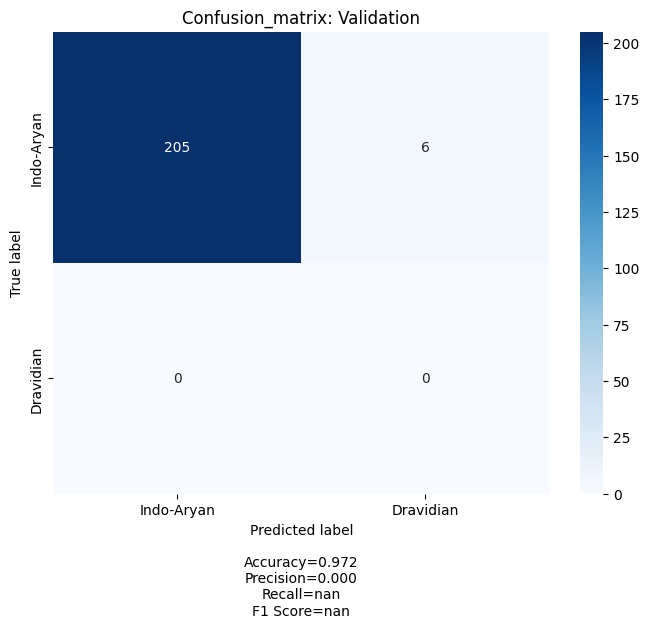

:::::Total validation loss 0.11623013521602843, Training accuracy 94.67226704985077%, Validation accuracy 97.1563981042654% after 0 epochs
Epoch: 1, Batch: 0, Loss: 0.2468794584274292, Accuracy: 98.4375%
Total training loss 0.13984365818194217 and training Accuracy 99.18204929810987% after 1 epochs
#####TEST--in-domain:::::Epoch: 1, Batch: 0, Loss: 0.6600871682167053, Accuracy:90.625%


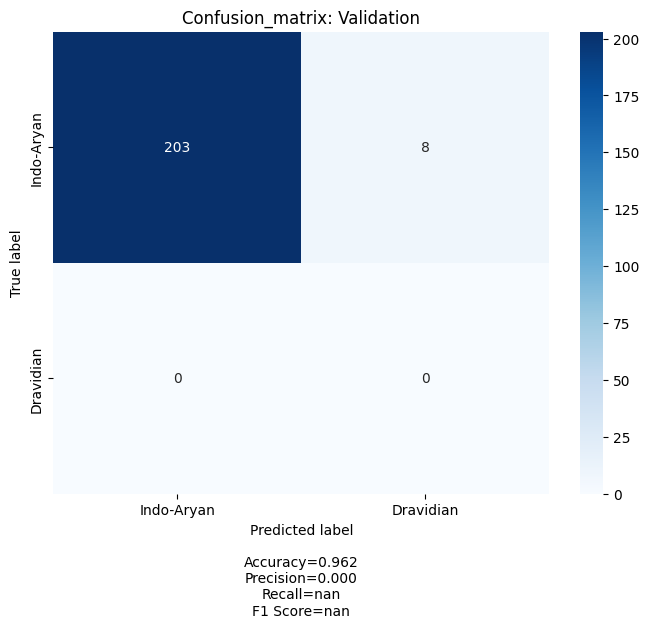

:::::Total validation loss 0.20230666955467314, Training accuracy 99.18204929810987%, Validation accuracy 96.2085308056872% after 1 epochs
Epoch: 2, Batch: 0, Loss: 0.06981527805328369, Accuracy: 99.21875%
Total training loss 0.07572253289011617 and training Accuracy 99.5025975461479% after 2 epochs
#####TEST--in-domain:::::Epoch: 2, Batch: 0, Loss: 0.22351491451263428, Accuracy:95.3125%


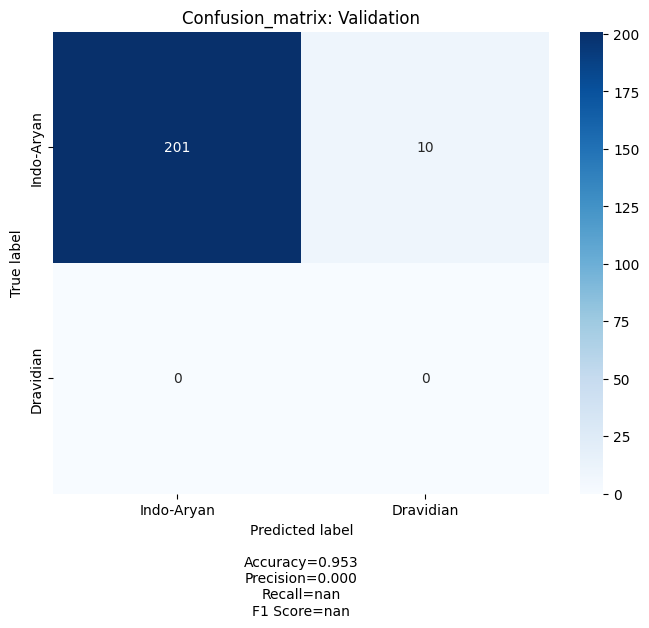

:::::Total validation loss 0.27358733490109444, Training accuracy 99.5025975461479%, Validation accuracy 95.260663507109% after 2 epochs
Epoch: 3, Batch: 0, Loss: 0.13699522614479065, Accuracy: 99.609375%
Total training loss 0.037206803469921904 and training Accuracy 99.85630595777606% after 3 epochs
#####TEST--in-domain:::::Epoch: 3, Batch: 0, Loss: 0.005378014873713255, Accuracy:100.0%


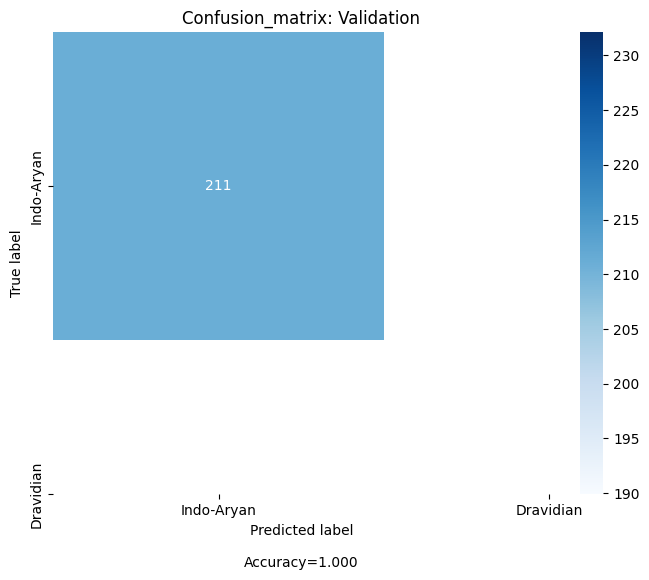

:::::Total validation loss 0.0013487240951732815, Training accuracy 99.85630595777606%, Validation accuracy 100.0% after 3 epochs
Epoch: 4, Batch: 0, Loss: 0.004695673938840628, Accuracy: 100.0%
Total training loss 0.05116788590061737 and training Accuracy 99.69050513982536% after 4 epochs
#####TEST--in-domain:::::Epoch: 4, Batch: 0, Loss: 0.20340818166732788, Accuracy:96.875%


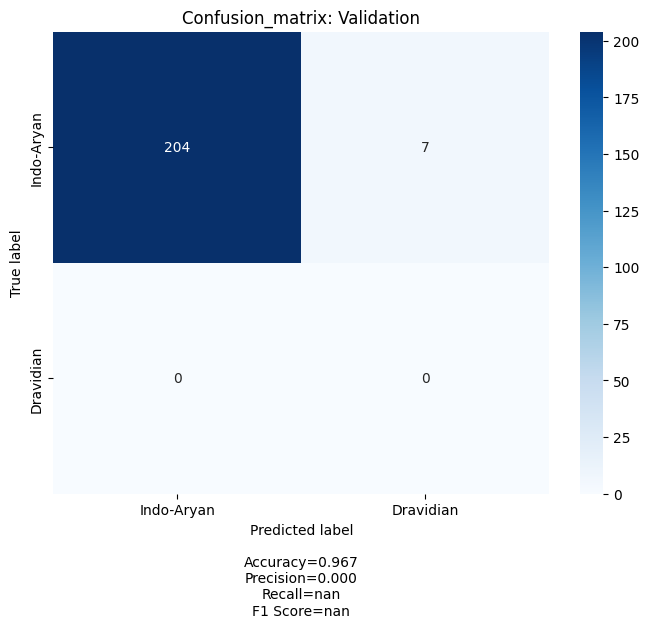

:::::Total validation loss 0.16036634774582126, Training accuracy 99.69050513982536%, Validation accuracy 96.6824644549763% after 4 epochs
Epoch: 5, Batch: 0, Loss: 0.00665557524189353, Accuracy: 100.0%
Total training loss 0.023765832226975665 and training Accuracy 99.87841273350281% after 5 epochs
#####TEST--in-domain:::::Epoch: 5, Batch: 0, Loss: 2.946233144029975e-05, Accuracy:100.0%


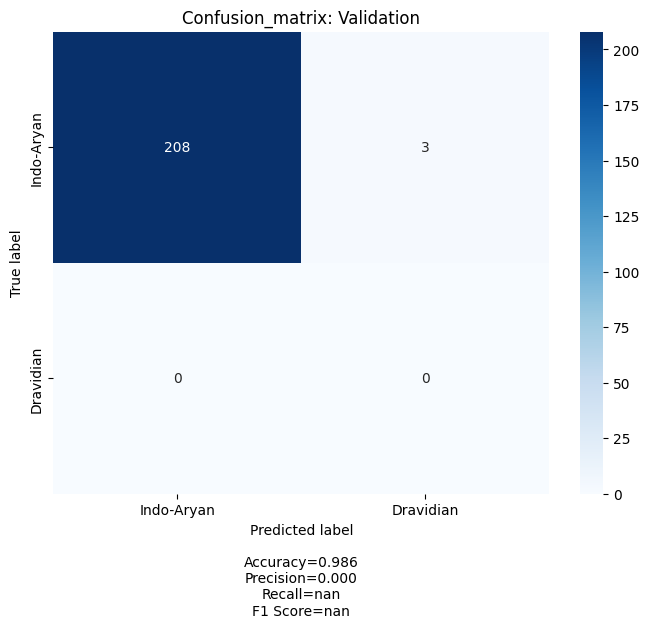

:::::Total validation loss 0.11944593930093106, Training accuracy 99.87841273350281%, Validation accuracy 98.5781990521327% after 5 epochs
Epoch: 6, Batch: 0, Loss: 0.0005375371547415853, Accuracy: 100.0%
Total training loss 0.010887319233445523 and training Accuracy 99.92262628495634% after 6 epochs
#####TEST--in-domain:::::Epoch: 6, Batch: 0, Loss: 3.7252898543727042e-09, Accuracy:100.0%


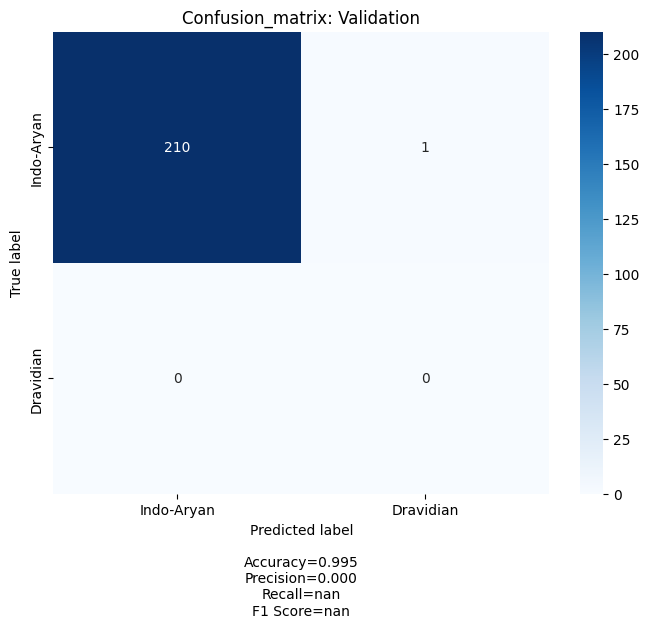

:::::Total validation loss 0.05704838770907361, Training accuracy 99.92262628495634%, Validation accuracy 99.52606635071089% after 6 epochs
Epoch: 7, Batch: 0, Loss: 0.003985673654824495, Accuracy: 100.0%
Total training loss 0.013434565389909872 and training Accuracy 99.91157289709295% after 7 epochs
#####TEST--in-domain:::::Epoch: 7, Batch: 0, Loss: 0.8566077947616577, Accuracy:92.1875%


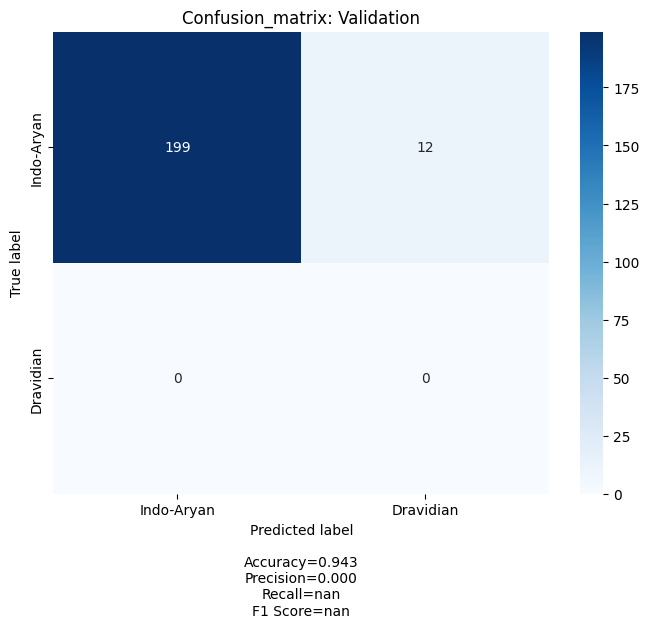

:::::Total validation loss 0.4530735551379621, Training accuracy 99.91157289709295%, Validation accuracy 94.3127962085308% after 7 epochs
Epoch: 8, Batch: 0, Loss: 0.03141571208834648, Accuracy: 99.609375%
Total training loss 0.0028721140553910926 and training Accuracy 99.98894661213662% after 8 epochs
#####TEST--in-domain:::::Epoch: 8, Batch: 0, Loss: 0.5284677147865295, Accuracy:95.3125%


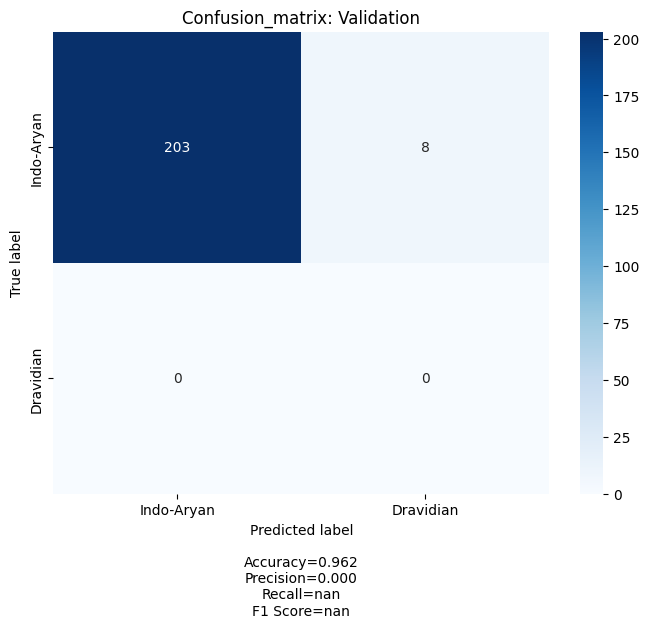

:::::Total validation loss 0.3582892268896103, Training accuracy 99.98894661213662%, Validation accuracy 96.2085308056872% after 8 epochs
Epoch: 9, Batch: 0, Loss: 7.465964699804317e-06, Accuracy: 100.0%
Total training loss 0.0016040574355721383 and training Accuracy 99.98894661213662% after 9 epochs
#####TEST--in-domain:::::Epoch: 9, Batch: 0, Loss: 0.17198438942432404, Accuracy:93.75%


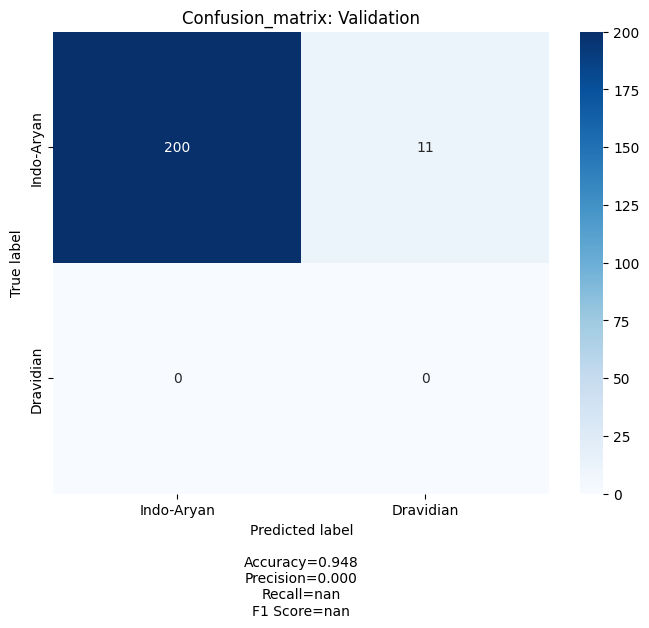

:::::Total validation loss 0.5963816754519939, Training accuracy 99.98894661213662%, Validation accuracy 94.7867298578199% after 9 epochs
Epoch: 10, Batch: 0, Loss: 0.00011934113717870787, Accuracy: 100.0%
Total training loss 0.0006087419034421041 and training Accuracy 100.0% after 10 epochs
#####TEST--in-domain:::::Epoch: 10, Batch: 0, Loss: 0.45123904943466187, Accuracy:92.1875%


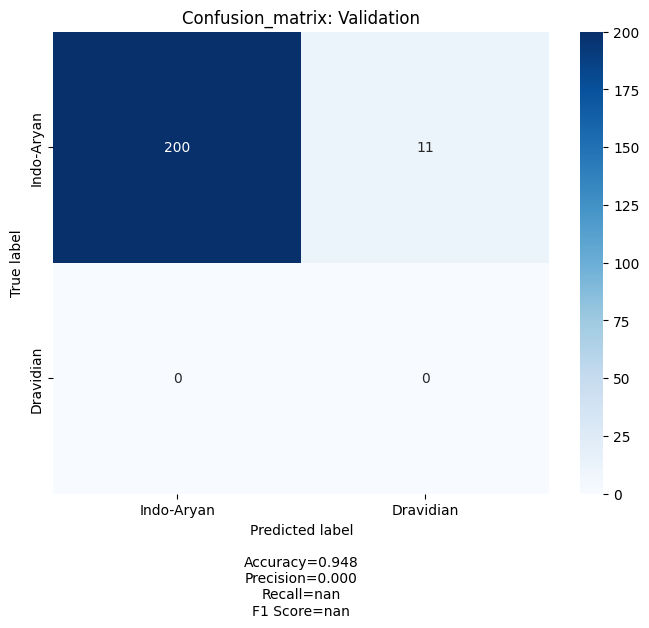

:::::Total validation loss 0.3195924308938629, Training accuracy 100.0%, Validation accuracy 94.7867298578199% after 10 epochs
Epoch: 11, Batch: 0, Loss: 3.2906744309002534e-05, Accuracy: 100.0%
Total training loss 4.0026352066667594e-05 and training Accuracy 100.0% after 11 epochs
#####TEST--in-domain:::::Epoch: 11, Batch: 0, Loss: 0.15281859040260315, Accuracy:96.875%


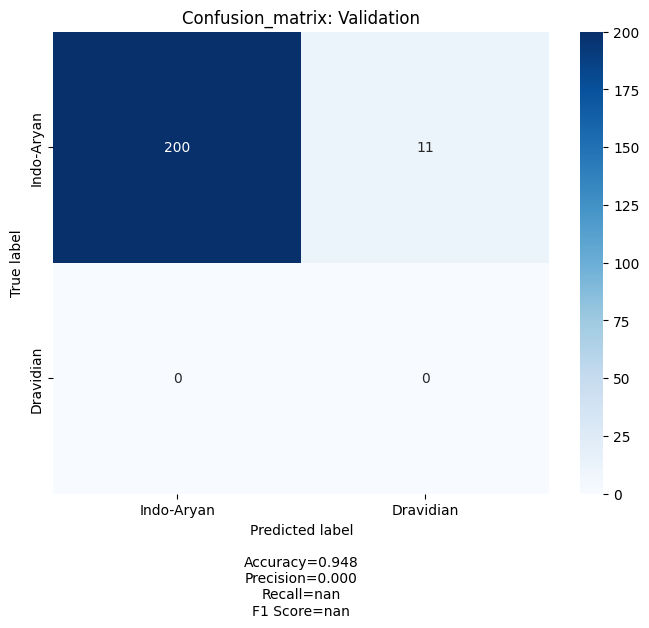

:::::Total validation loss 0.5530306473374367, Training accuracy 100.0%, Validation accuracy 94.7867298578199% after 11 epochs
Epoch: 12, Batch: 0, Loss: 1.9566052287700586e-05, Accuracy: 100.0%
Total training loss 0.0016503547753051369 and training Accuracy 100.0% after 12 epochs
#####TEST--in-domain:::::Epoch: 12, Batch: 0, Loss: 0.47386690974235535, Accuracy:93.75%


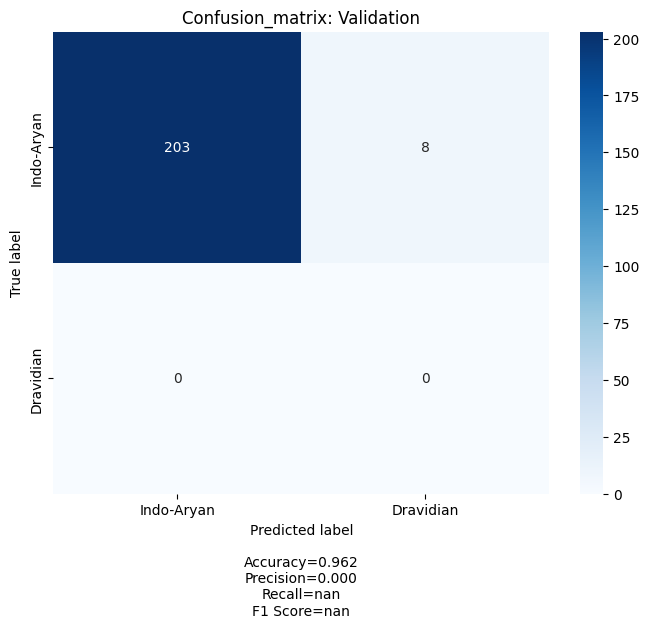

:::::Total validation loss 0.23421228281222284, Training accuracy 100.0%, Validation accuracy 96.2085308056872% after 12 epochs
Epoch: 13, Batch: 0, Loss: 1.4031455975782592e-05, Accuracy: 100.0%
Total training loss 0.0011369487685581386 and training Accuracy 100.0% after 13 epochs
#####TEST--in-domain:::::Epoch: 13, Batch: 0, Loss: 0.23175621032714844, Accuracy:96.875%


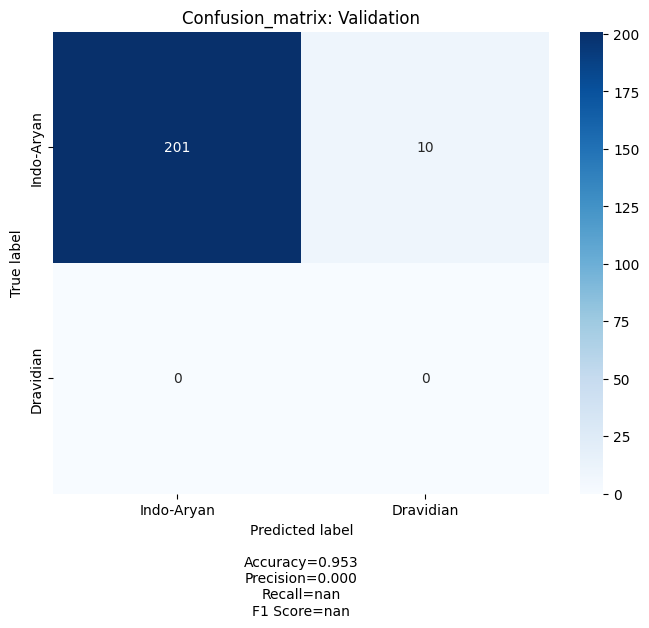

:::::Total validation loss 0.4836721643805504, Training accuracy 100.0%, Validation accuracy 95.260663507109% after 13 epochs
Epoch: 14, Batch: 0, Loss: 2.4809985916363075e-05, Accuracy: 100.0%
Total training loss 0.0003646492735651405 and training Accuracy 100.0% after 14 epochs
#####TEST--in-domain:::::Epoch: 14, Batch: 0, Loss: 0.19719912111759186, Accuracy:95.3125%


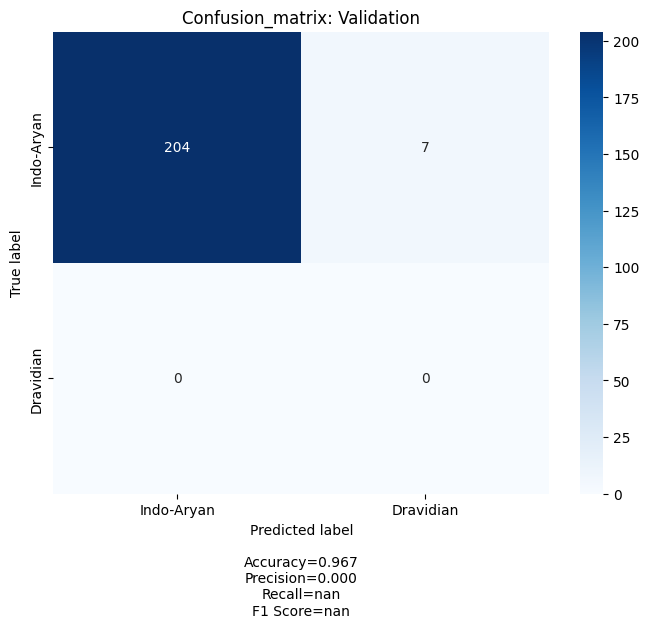

:::::Total validation loss 0.17799850566734676, Training accuracy 100.0%, Validation accuracy 96.6824644549763% after 14 epochs
Epoch: 15, Batch: 0, Loss: 7.76228480390273e-05, Accuracy: 100.0%
Total training loss 6.128653939343722e-05 and training Accuracy 100.0% after 15 epochs
#####TEST--in-domain:::::Epoch: 15, Batch: 0, Loss: 0.3046693205833435, Accuracy:95.3125%


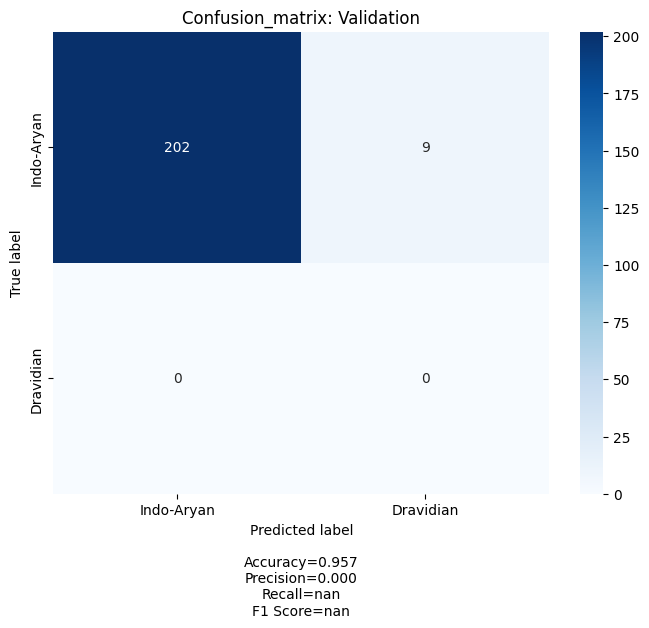

:::::Total validation loss 0.21376824663265692, Training accuracy 100.0%, Validation accuracy 95.73459715639811% after 15 epochs
Epoch: 16, Batch: 0, Loss: 5.313736983225681e-05, Accuracy: 100.0%
Total training loss 0.00013209160533161283 and training Accuracy 100.0% after 16 epochs
#####TEST--in-domain:::::Epoch: 16, Batch: 0, Loss: 0.20621059834957123, Accuracy:96.875%


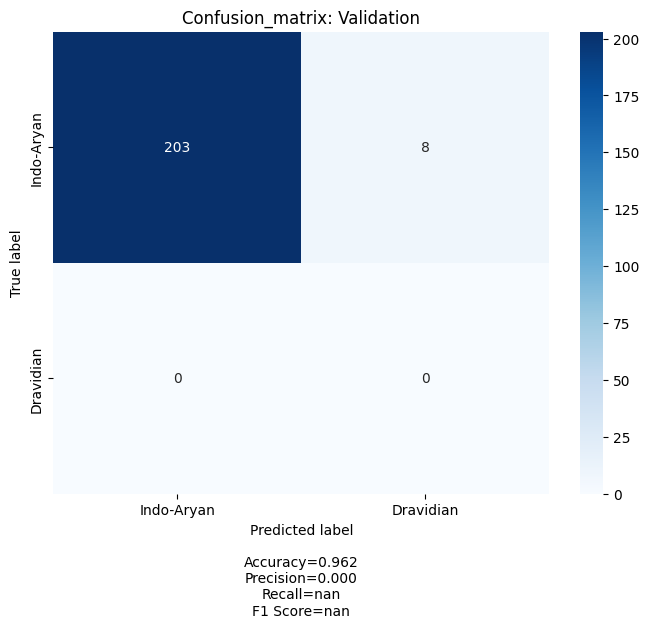

:::::Total validation loss 0.1874584350734949, Training accuracy 100.0%, Validation accuracy 96.2085308056872% after 16 epochs
Epoch: 17, Batch: 0, Loss: 6.542373967022286e-07, Accuracy: 100.0%
Total training loss 0.0003291936676013623 and training Accuracy 100.0% after 17 epochs
#####TEST--in-domain:::::Epoch: 17, Batch: 0, Loss: 0.2615332007408142, Accuracy:95.3125%


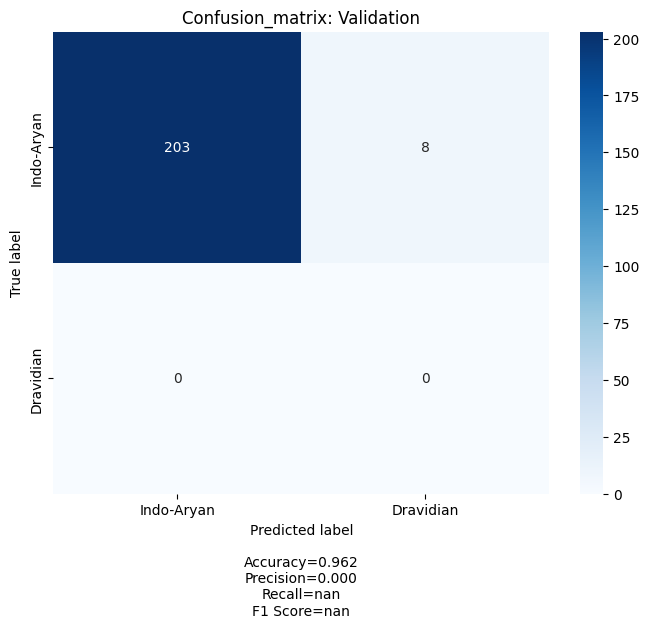

:::::Total validation loss 0.18155040219426155, Training accuracy 100.0%, Validation accuracy 96.2085308056872% after 17 epochs
Epoch: 18, Batch: 0, Loss: 6.7862247306038626e-06, Accuracy: 100.0%
Total training loss 3.0596026020882995e-05 and training Accuracy 100.0% after 18 epochs
#####TEST--in-domain:::::Epoch: 18, Batch: 0, Loss: 0.036195721477270126, Accuracy:98.4375%


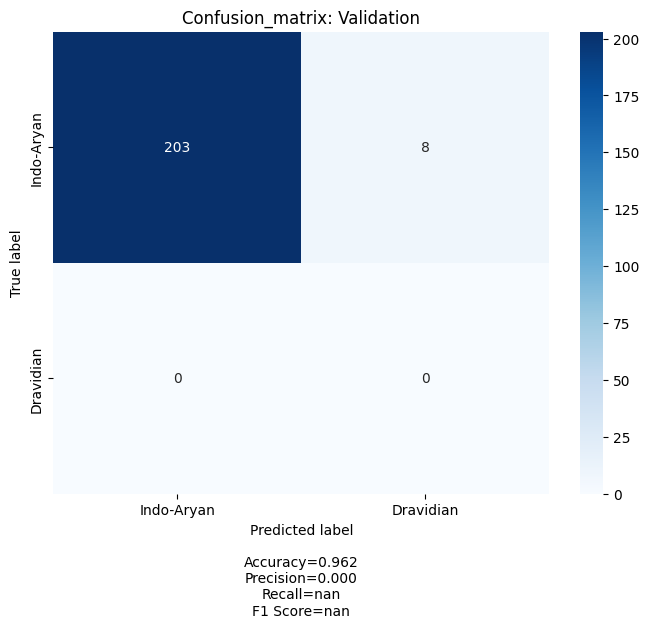

:::::Total validation loss 0.2890329398214817, Training accuracy 100.0%, Validation accuracy 96.2085308056872% after 18 epochs
Epoch: 19, Batch: 0, Loss: 8.991307822725503e-07, Accuracy: 100.0%
Total training loss 0.00019075109569044457 and training Accuracy 100.0% after 19 epochs
#####TEST--in-domain:::::Epoch: 19, Batch: 0, Loss: 0.15758192539215088, Accuracy:98.4375%


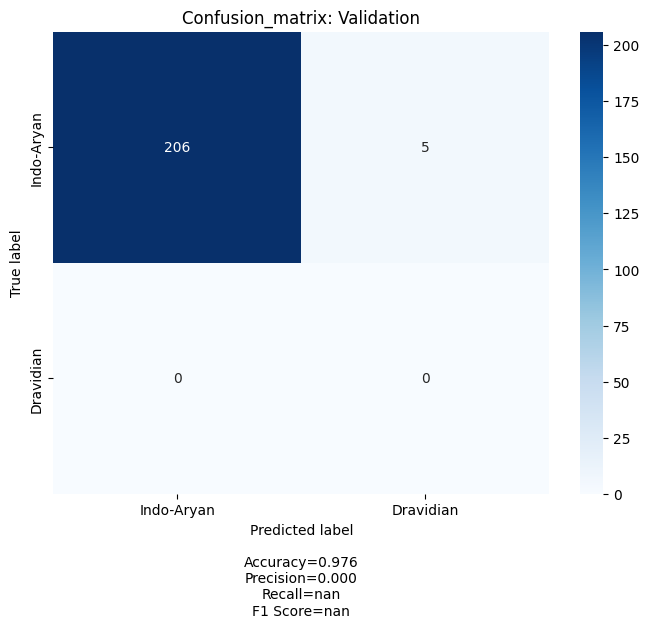

:::::Total validation loss 0.13124098234129633, Training accuracy 100.0%, Validation accuracy 97.6303317535545% after 19 epochs
Epoch: 20, Batch: 0, Loss: 4.032562515021709e-07, Accuracy: 100.0%
Total training loss 0.0004470072630914738 and training Accuracy 100.0% after 20 epochs
#####TEST--in-domain:::::Epoch: 20, Batch: 0, Loss: 0.2237643599510193, Accuracy:96.875%


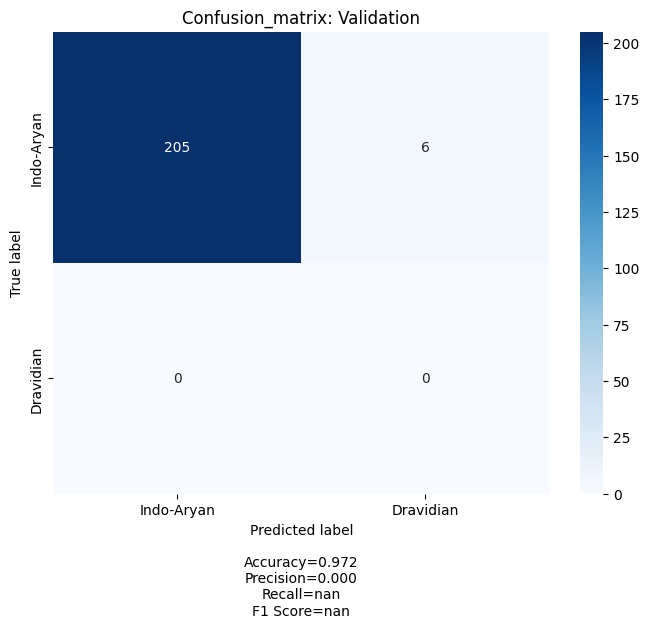

:::::Total validation loss 0.143846848929428, Training accuracy 100.0%, Validation accuracy 97.1563981042654% after 20 epochs
Epoch: 21, Batch: 0, Loss: 2.5542822186253034e-06, Accuracy: 100.0%
Total training loss 0.000555286974648597 and training Accuracy 100.0% after 21 epochs
#####TEST--in-domain:::::Epoch: 21, Batch: 0, Loss: 0.2943517863750458, Accuracy:95.3125%


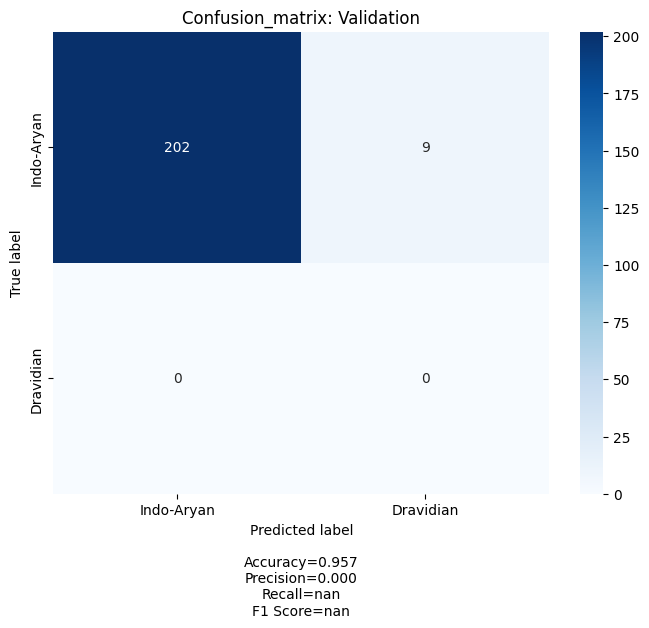

:::::Total validation loss 0.24875467427467035, Training accuracy 100.0%, Validation accuracy 95.73459715639811% after 21 epochs
Epoch: 22, Batch: 0, Loss: 0.00010204385762335733, Accuracy: 100.0%
Total training loss 3.55806370168447e-05 and training Accuracy 100.0% after 22 epochs
#####TEST--in-domain:::::Epoch: 22, Batch: 0, Loss: 0.3013552725315094, Accuracy:96.875%


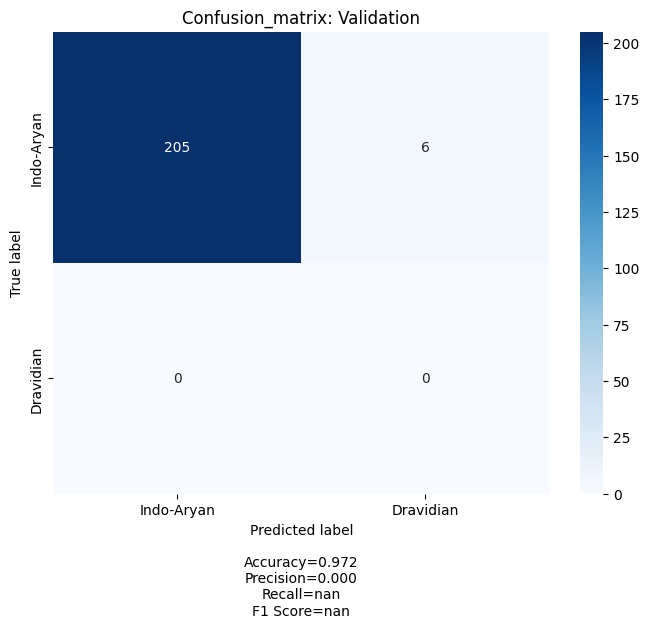

:::::Total validation loss 0.1623217649757862, Training accuracy 100.0%, Validation accuracy 97.1563981042654% after 22 epochs
Epoch: 23, Batch: 0, Loss: 2.849815246008802e-07, Accuracy: 100.0%


KeyboardInterrupt: 

: 

In [9]:
import warnings
warnings.filterwarnings('ignore')
dest_path = "/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/"
os.makedirs(dest_path, exist_ok=True)

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cf_matrix

def train(dataloader_train, epoch):
    train_loss_list = []
    train_acc_list = []
    full_preds = []
    full_gts = []

    model.train()
    for i_batch, data in enumerate(dataloader_train, 0):
        features, labels = data
        features, labels = features.to(device).float(), labels.to(device).long()
        features.requires_grad = True
        optimizer.zero_grad()
        pred_logits = model(features)
        loss = model.get_loss(pred_logits, labels)
        posterior = model.get_posterior()

        loss.backward()
        optimizer.step()
        predictions = np.argmax(posterior.detach().cpu().numpy(), axis=1)
        if i_batch % 50 == 0:
            acc = accuracy_score(predictions, labels.cpu())
            print(f"Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy: {acc*100}%")
        train_loss_list.append(loss.item())
        full_preds.extend(predictions)
        full_gts.extend(labels.detach().cpu().numpy())

    mean_acc = accuracy_score(full_gts, full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    print(f'Total training loss {mean_loss} and training Accuracy {mean_acc*100}% after {epoch} epochs')
    return mean_acc

def validation(dataloader_val, epoch, train_accuracy):
    model.eval()
    with torch.no_grad():
        val_loss_list = []
        full_preds = []
        full_gts = []
        for i_batch, data in enumerate(dataloader_val, 0):
            features, labels = data
            features, labels = features.to(device).float(), labels.to(device).long()
            pred_logits = model(features)
            loss = model.get_loss(pred_logits, labels)
            posterior = model.get_posterior()
            val_loss_list.append(loss.item())
            predictions = np.argmax(posterior.detach().cpu().numpy(), axis=1)
            if i_batch % 50 == 0:
                acc = accuracy_score(predictions, labels.cpu())
                print(f"#####TEST--in-domain:::::Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
            full_preds.extend(predictions)
            full_gts.extend(labels.detach().cpu().numpy())

        mean_acc2 = accuracy_score(full_gts, full_preds)
        mean_loss2 = np.mean(np.asarray(val_loss_list))
        cm = confusion_matrix(full_gts, full_preds)
        cf_matrix.make_confusion_matrix(cm, percent=False, figsize=(8, 6), categories=["Indo-Aryan", "Dravidian"], cbar=True, title="Confusion_matrix: Validation")
        plt.show()
        print(f':::::Total validation loss {mean_loss2}, Training accuracy {train_accuracy*100}%, Validation accuracy {mean_acc2*100}% after {epoch} epochs')
        model_save_path = os.path.join(dest_path, f'No_Hindi_North_south_binary_Bhagya_ecapa_cms_{train_accuracy*100:.3f}_{mean_acc2*100:.3f}_{mean_loss2:.4f}')
        state_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
        torch.save(state_dict, model_save_path)
        return loss

if __name__ == '__main__':
    for epoch in range(50):
        mean_acc = train(trainloader, epoch)
        val_loss = validation(testloader1, epoch, mean_acc)
        scheduler.step(val_loss)